In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
# from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
# alpha = Right Ascension angle (at J2000 epoch)
# delta = Declination angle (at J2000 epoch)
# u = Ultraviolet filter in the photometric system
# g = Green filter in the photometric system
# r = Red filter in the photometric system
# i = Near Infrared filter in the photometric system
# z = Infrared filter in the photometric system
# run_ID = Run Number used to identify the specific scan
# rereun_ID = Rerun Number to specify how the image was processed
# cam_col = Camera column to identify the scanline within the run
# field_ID = Field number to identify each field
# spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
# class = object class (galaxy, star or quasar object)
# redshift = redshift value based on the increase in wavelength
# plate = plate ID, identifies each plate in SDSS
# MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
# fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

In [3]:
star = pd.read_csv('star_classification.csv')
star.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
star["class"].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

In [6]:
star["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in star["class"]]

In [56]:
star["class"].value_counts(normalize=True)

0    0.594456
1    0.215932
2    0.189612
Name: class, dtype: float64

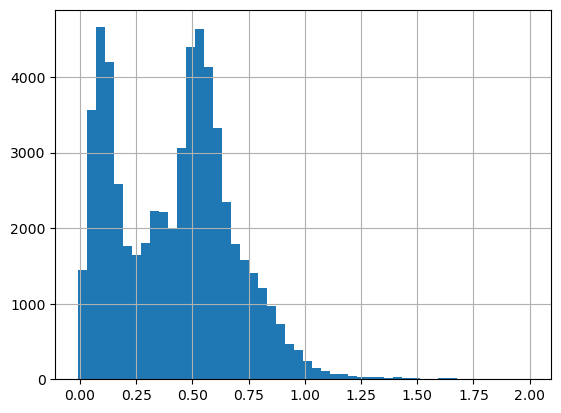

In [52]:
star[star['class']==0]['redshift'].hist(bins=50);

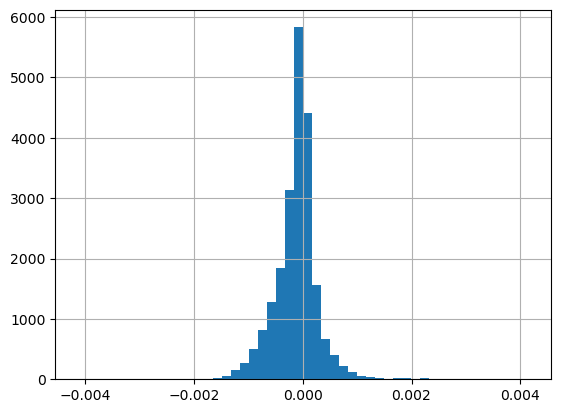

In [55]:
star[star['class']==1]['redshift'].hist(bins=50); # I am seeing something illogical - Why are the QSO objects centered at 0 for red shift? NEgative redshift?!

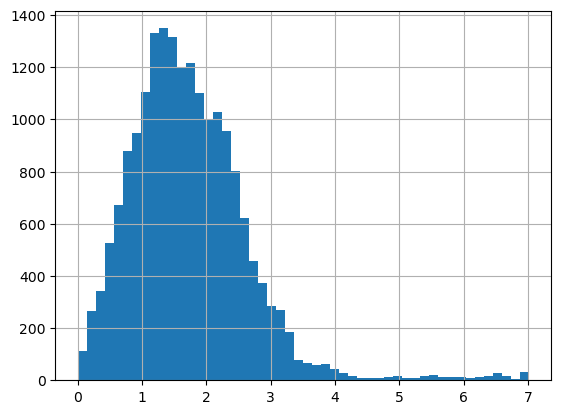

In [54]:
star[star['class']==2]['redshift'].hist(bins=50);

In [8]:
# from sklearn.neighbors import LocalOutlierFactor
# clf = LocalOutlierFactor()
# y_pred = clf.fit_predict(df)

<Axes: >

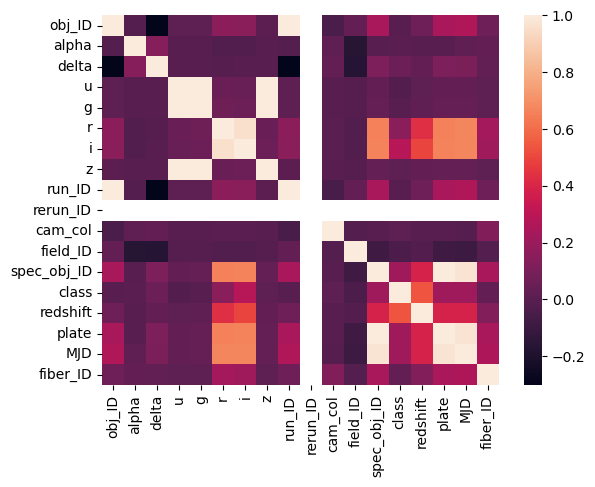

In [9]:
sns.heatmap(star.corr())

In [10]:
star.corr()['class'].sort_values()

field_ID      -0.038044
u             -0.017701
g             -0.005915
run_ID        -0.000049
obj_ID        -0.000047
alpha          0.004552
cam_col        0.014476
z              0.017352
fiber_ID       0.032053
delta          0.056643
r              0.150691
MJD            0.207262
spec_obj_ID    0.215722
plate          0.215722
i              0.284396
redshift       0.536822
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

In [11]:
star['run_ID'].value_counts()

3699    2450
4263    2295
3225    2275
2964    2009
7717    1782
        ... 
6514       1
1336       1
297        1
287        1
6074       1
Name: run_ID, Length: 430, dtype: int64

In [12]:
star['field_ID'].value_counts() 

71     472
65     458
67     449
60     448
69     447
      ... 
748      1
977      1
979      1
974      1
934      1
Name: field_ID, Length: 856, dtype: int64

In [13]:
star['rerun_ID'].value_counts() # drop

301    100000
Name: rerun_ID, dtype: int64

In [14]:
star['plate'].value_counts()

6301    98
7699    97
7407    96
7147    95
6516    94
        ..
2512     1
5745     1
2818     1
1709     1
2661     1
Name: plate, Length: 6284, dtype: int64

In [15]:
star['MJD'].value_counts()

56625    249
58162    228
56658    217
56390    216
56385    201
        ... 
55517      1
54894      1
53075      1
53906      1
52054      1
Name: MJD, Length: 2180, dtype: int64

In [16]:
star['MJD'].describe()

count    100000.000000
mean      55588.647500
std        1808.484233
min       51608.000000
25%       54234.000000
50%       55868.500000
75%       56777.000000
max       58932.000000
Name: MJD, dtype: float64

In [17]:
star['fiber_ID'].value_counts()

637    159
105    158
597    158
611    154
321    154
      ... 
746     50
744     49
942     48
768     47
906     45
Name: fiber_ID, Length: 1000, dtype: int64

In [18]:
star['spec_obj_ID'].value_counts()

6.543777e+18    1
5.644169e+18    1
9.834876e+18    1
3.301259e+18    1
4.864118e+18    1
               ..
7.642688e+18    1
5.787208e+17    1
5.205269e+18    1
4.486928e+18    1
8.343152e+18    1
Name: spec_obj_ID, Length: 100000, dtype: int64

In [19]:
star = star[star['z']>0]

In [20]:
star.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
count,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.0,99999.000000,99999.000000,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,1.237665e+18,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,4481.403354,301.0,3.511625,186.127011,5.783903e+18,0.595156,0.576667,5137.027890,55588.653687,449.315613
std,8.438450e+12,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,1964.739021,0.0,1.586913,149.007687,3.324026e+18,0.787512,0.730709,2952.312485,1808.492217,272.498252
min,1.237646e+18,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,109.000000,301.0,1.000000,11.000000,2.995191e+17,0.000000,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,3187.000000,301.0,2.000000,82.000000,2.844137e+18,0.000000,0.054522,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,4188.000000,301.0,4.000000,146.000000,5.614896e+18,0.000000,0.424176,4987.000000,55869.000000,433.000000
75%,1.237668e+18,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,5326.000000,301.0,5.000000,241.000000,8.332365e+18,1.000000,0.704172,7400.500000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,2.000000,7.011245,12547.000000,58932.000000,1000.000000


In [21]:
star = star.drop(columns=['rerun_ID','run_ID','obj_ID','spec_obj_ID','field_ID'])#'plate','fiber_ID','alpha','delta','cam_col','MJD',
star.head()

,alpha,delta,u,g,r,i,z,cam_col,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0,0.116123,6121,56187,842


In [22]:
#!pip install scikit-learn==1.2.2

In [23]:
X = star.drop(columns=['class'])
y = star['class']


### Used smote (Synthetic Minority Over-sampling Technique) to balance classes

In [24]:
sm = SMOTE(random_state=512)
print('Original dataset shape %s' % Counter(y))
X, y = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 59445, 1: 21593, 2: 18961})
Resampled dataset shape Counter({0: 59445, 2: 59445, 1: 59445})


In [25]:
X.head()

,alpha,delta,u,g,r,i,z,cam_col,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0.116123,6121,56187,842


In [26]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=512)

In [27]:
### Standard Scale my features ---- 
# sc = StandardScaler()
# X_train_sc = sc.fit_transform(X_train)
# X_test_sc = sc.transform(X_test)

In [28]:
rf =RandomForestClassifier()
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.9832899694957833

In [29]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14856
           1       1.00      1.00      1.00     14748
           2       0.98      0.97      0.98     14980

    accuracy                           0.98     44584
   macro avg       0.98      0.98      0.98     44584
weighted avg       0.98      0.98      0.98     44584



In [30]:
# Guessing stars is 100 percent
# Why is it confusing galaxies and Quasars
# What is at the galactic centers? Black holes
# Bayes error: lesson on what a Quazar is

In [31]:
star.head()

,alpha,delta,u,g,r,i,z,cam_col,class,redshift,plate,MJD,fiber_ID
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,0,0.634794,5812,56354,171
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,0,0.779136,10445,58158,427
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,0,0.644195,4576,55592,299
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,0,0.932346,9149,58039,775
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,0,0.116123,6121,56187,842


In [ ]:
# GridSearch to imrove accuracy

In [39]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [42]:
rf1=RandomForestClassifier(random_state=512)
gs = RandomizedSearchCV(rf1,param_grid,cv=5,scoring='accuracy', n_iter=100, n_jobs=4)
gs.fit(X_train,y_train)

C:\Users\seanh\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=512),
                   n_iter=100, n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [100, 200, 500]},
                   scoring='accuracy')

In [43]:
print("Best Hyperparameters:", gs.best_params_)

Best Hyperparameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


In [44]:
best_rf_model = gs.best_estimator_

In [45]:
gs.score(X_test,y_test)

0.9847927507626054

In [57]:
print(confusion_matrix(y_test, gs.predict(X_test)))

[[14552    52   252]
 [    2 14746     0]
 [  372     0 14608]]


In [46]:
param_grid2 = {
    'n_estimators': [50,75,100,125,150],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [47]:
rf2=RandomForestClassifier(random_state=512)
gs2 = GridSearchCV(rf2,param_grid2,cv=5,scoring='accuracy', n_jobs=4)
gs2.fit(X_train,y_train)
gs2.score(X_test,y_test)

0.9847478916203122

In [48]:
best_rf_model

RandomForestClassifier(bootstrap=False, random_state=512)

In [49]:
print("Best Hyperparameters:", gs2.best_params_)

Best Hyperparameters: {'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125}


In [32]:
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Load your dataset
# # ...

# # Use LOF to detect and remove outliers
# lof = LocalOutlierFactor()
# outlier_mask = lof.fit_predict(X) != -1  # -1 indicates an outlier
# X_no_outliers = X[outlier_mask]
# y_no_outliers = y[outlier_mask]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# # Train a classification model
# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)

# # Evaluate the model
# y_pred = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")